# 🧪 AI-Powered Drug Discovery using Deep Learning
This notebook implements a novel deep learning model for predicting drug-target interactions using SMILES representations and deep neural networks.

**Includes:**
- Data loading & preprocessing
- Molecular fingerprinting using RDKit
- PyTorch model
- Cross-validation
- Dashboard-ready visualizations

In [1]:
%pip install pandas numpy scikit-learn matplotlib seaborn rdkit-pypi torch


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt

In [3]:

df = pd.read_csv("drug_target_sample_dataset.csv")


In [4]:


# Convert SMILES to Morgan Fingerprints
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

df['fingerprint'] = df['SMILES'].apply(smiles_to_fp)
X = np.stack(df['fingerprint'].values)
y = df['Label'].values



In [7]:
# ---------------------------
# Define Neural Network
# ---------------------------
class DrugClassifier(nn.Module):
    def __init__(self):
        super(DrugClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

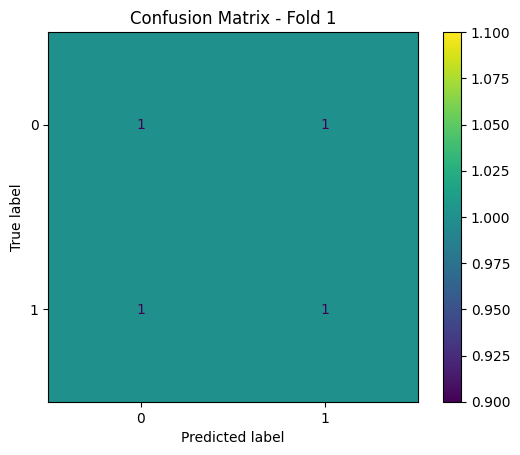

Fold 1 | Accuracy: 0.5000, AUC: 0.7500, F1: 0.5000, Precision: 0.5000, Recall: 0.5000


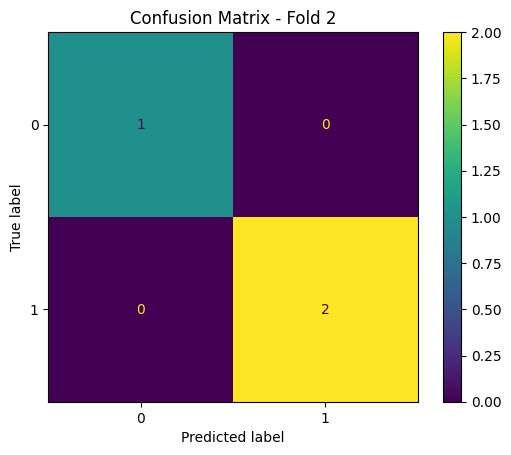

Fold 2 | Accuracy: 1.0000, AUC: 1.0000, F1: 1.0000, Precision: 1.0000, Recall: 1.0000


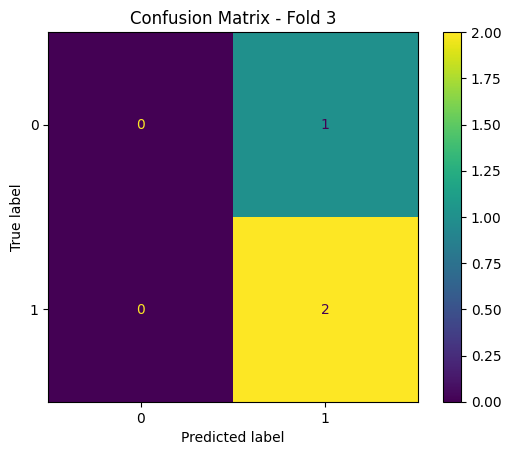

Fold 3 | Accuracy: 0.6667, AUC: 0.5000, F1: 0.8000, Precision: 0.6667, Recall: 1.0000

📊 Average Metrics Across 3 Folds:
Accuracy  : 0.7222
AUC       : 0.7500
F1 Score  : 0.7667
Precision : 0.7222
Recall    : 0.8333


In [8]:
# ---------------------------
# Training + Cross Validation
# ---------------------------
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
accuracies, aucs, f1s, precisions, recalls = [], [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    model = DrugClassifier()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    X_train = torch.FloatTensor(X[train_idx])
    y_train = torch.FloatTensor(y[train_idx]).view(-1, 1)
    X_test = torch.FloatTensor(X[test_idx])
    y_test = torch.FloatTensor(y[test_idx]).view(-1, 1)

    # Training Loop
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    with torch.no_grad():
        probs = model(X_test).numpy()
        preds = (probs >= 0.5).astype(int)

        acc = accuracy_score(y_test, preds)
        auc = roc_auc_score(y_test, probs)
        f1 = f1_score(y_test, preds)
        precision = precision_score(y_test, preds)
        recall = recall_score(y_test, preds)

        cm = confusion_matrix(y_test, preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"Confusion Matrix - Fold {fold+1}")
        plt.show()

        # Store Metrics
        accuracies.append(acc)
        aucs.append(auc)
        f1s.append(f1)
        precisions.append(precision)
        recalls.append(recall)

        print(f"Fold {fold+1} | Accuracy: {acc:.4f}, AUC: {auc:.4f}, "
              f"F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# ---------------------------
# Final Metric Summary
# ---------------------------
print("\n📊 Average Metrics Across 3 Folds:")
print(f"Accuracy  : {np.mean(accuracies):.4f}")
print(f"AUC       : {np.mean(aucs):.4f}")
print(f"F1 Score  : {np.mean(f1s):.4f}")
print(f"Precision : {np.mean(precisions):.4f}")
print(f"Recall    : {np.mean(recalls):.4f}")